Nombre total d'annotations : 112
Nombre de plaques trouvées : 45
Base autorisée construite : 6
⚠️ Multiple matches found (2 matches):
   - mat3.png: score=2, keypoints=54
   - matricule1.png: score=1, keypoints=120

Vérification : ccc1a2d44a290368_jpg.rf.8e8d6f87f1d1327caf5f80e0c96cdad9.jpg
Descripteurs extraits: (36, 128)
Score obtenu: 2 / 6
Max score from first match: 2
X REFUSÉ  : ( 
Score max trouvé : 2
⚠️ Multiple matches found (3 matches):
   - mat1.png: score=2, keypoints=23
   - mat2.png: score=2, keypoints=14
   - matricule1.png: score=2, keypoints=120

Vérification : b6580dec5ada277d_jpg.rf.3ec17c0d68df1e6818d590e410bc3d00.jpg
Descripteurs extraits: (72, 128)
Score obtenu: 2 / 6
Max score from first match: 2
X REFUSÉ  : ( 
Score max trouvé : 2

Vérification : b1a50a3824887ee2_jpg.rf.68a4fd34fce20184287592f2680f895b.jpg
Descripteurs extraits: (51, 128)
Score obtenu: 1 / 6
Max score from first match: 1
X REFUSÉ  : ( 
Score max trouvé : 1
!!!!! Skipped b1a50a3824887ee2_jpg.rf.68

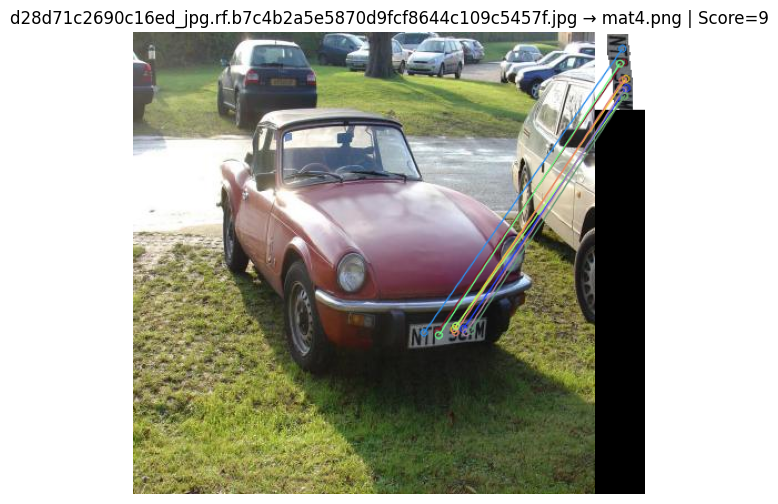

⚠️ Multiple matches found (3 matches):
   - mat1.png: score=3, keypoints=23
   - mat3.png: score=1, keypoints=54
   - query.png: score=2, keypoints=139

Vérification : c91ee912164d8ecb_jpg.rf.5a70d8b40bde25a3a4cb09337bf0c6f9.jpg
Descripteurs extraits: (70, 128)
Score obtenu: 3 / 6
Max score from first match: 3
X REFUSÉ  : ( 
Score max trouvé : 3

Vérification : b8a3f2ea385e45b3_jpg.rf.1b19b61606bd9199fa0f774c35cf8986.jpg
Descripteurs extraits: (1, 128)
Score obtenu: 0 / 6
X REFUSÉ  : ( 
Score max trouvé : 0

Vérification : b8a3f2ea385e45b3_jpg.rf.1b19b61606bd9199fa0f774c35cf8986.jpg
Descripteurs extraits: (8, 128)
Score obtenu: 0 / 6
X REFUSÉ  : ( 
Score max trouvé : 0

Vérification : b8a3f2ea385e45b3_jpg.rf.1b19b61606bd9199fa0f774c35cf8986.jpg
Descripteurs extraits: (3, 128)
Score obtenu: 0 / 6
X REFUSÉ  : ( 
Score max trouvé : 0
⚠️ Multiple matches found (2 matches):
   - mat1.png: score=7, keypoints=23
   - query.png: score=1, keypoints=139

Vérification : b7cdb5c0c99002b7_jpg.rf.2c

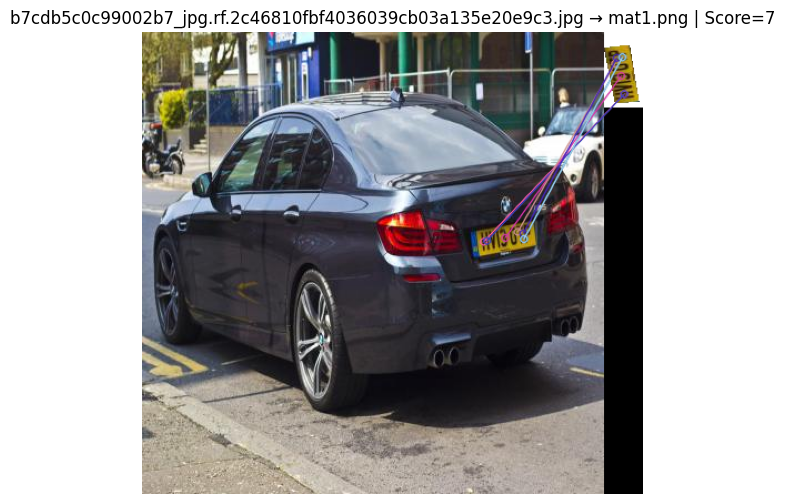


Vérification : cb8c75fc1c7ccf73_jpg.rf.a6d315cf4a3ef0824075df8c8561838b.jpg
Descripteurs extraits: (73, 128)
Score obtenu: 1 / 6
Max score from first match: 1
X REFUSÉ  : ( 
Score max trouvé : 1
⚠️ Multiple matches found (2 matches):
   - mat1.png: score=1, keypoints=23
   - mat2.png: score=2, keypoints=14

Vérification : c650ff8d3e8e75b3_jpg.rf.a469a8f0edb8fddf8e2b70b102f5a5eb.jpg
Descripteurs extraits: (44, 128)
Score obtenu: 2 / 6
Max score from first match: 1
X REFUSÉ  : ( 
Score max trouvé : 2

Vérification : b193070a9c45b5ab_jpg.rf.57e5987eb896a7bf9fc7a1a96a660c7e.jpg
Descripteurs extraits: (23, 128)
Score obtenu: 0 / 6
X REFUSÉ  : ( 
Score max trouvé : 0
⚠️ Multiple matches found (3 matches):
   - mat1.png: score=3, keypoints=23
   - mat3.png: score=2, keypoints=54
   - query.png: score=1, keypoints=139

Vérification : d027c6e32db60e3c_jpg.rf.15a865d02f390ef84fca8e053946db31.jpg
Descripteurs extraits: (32, 128)
Score obtenu: 3 / 6
Max score from first match: 3
X REFUSÉ  : ( 
Sc

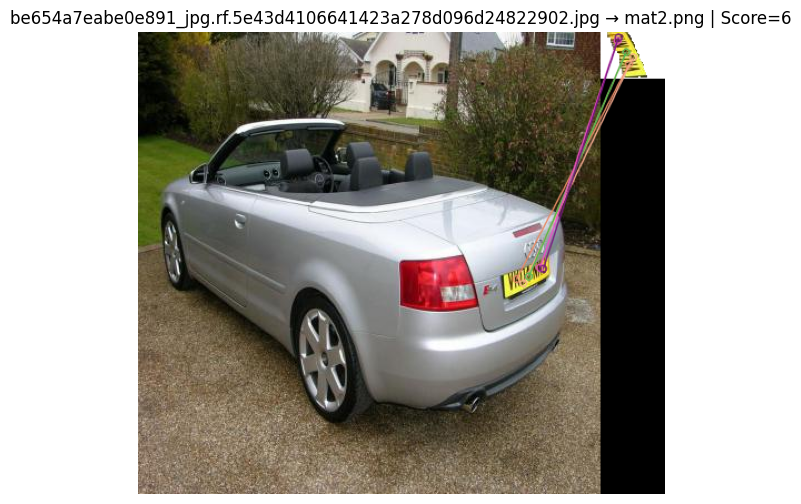

⚠️ Multiple matches found (4 matches):
   - mat1.png: score=1, keypoints=23
   - mat4.png: score=1, keypoints=40
   - matricule1.png: score=1, keypoints=120
   - query.png: score=1, keypoints=139

Vérification : cdb1e8621d1c624e_jpg.rf.b744b93a7af0771f1e5cb955155c8451.jpg
Descripteurs extraits: (103, 128)
Score obtenu: 1 / 6
Max score from first match: 1
X REFUSÉ  : ( 
Score max trouvé : 1
⚠️ Multiple matches found (3 matches):
   - mat3.png: score=2, keypoints=54
   - mat4.png: score=2, keypoints=40
   - query.png: score=2, keypoints=139

Vérification : d27e094e98374ff8_jpg.rf.a0e0eba539117b97eb6433295c4cfb44.jpg
Descripteurs extraits: (74, 128)
Score obtenu: 2 / 6
Max score from first match: 2
X REFUSÉ  : ( 
Score max trouvé : 2
!!!!!  Skipped cb4b754537798d23_jpg.rf.310e3c4544bf89d2f3109956b301db20.jpg (invalid bounding box)

Vérification : cb4b754537798d23_jpg.rf.310e3c4544bf89d2f3109956b301db20.jpg
Descripteurs extraits: (4, 128)
Score obtenu: 0 / 6
X REFUSÉ  : ( 
Score max trouvé

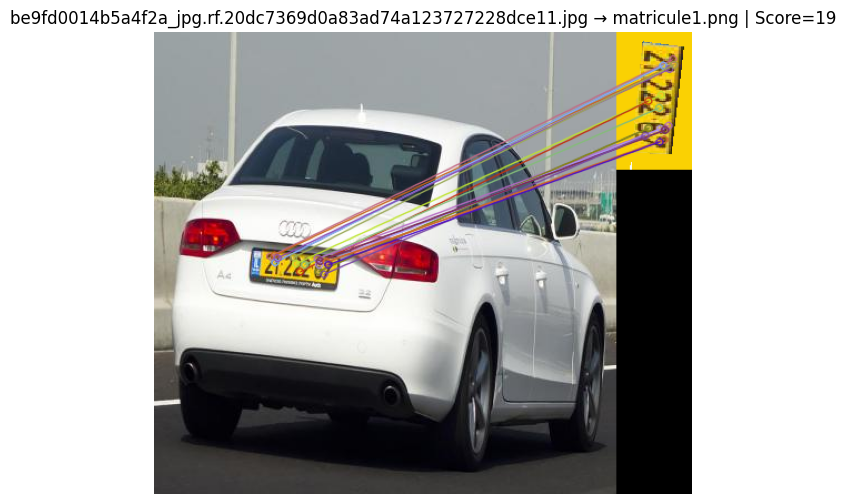

⚠️ Multiple matches found (6 matches):
   - mat1.png: score=5, keypoints=23
   - mat2.png: score=4, keypoints=14
   - mat3.png: score=3, keypoints=54
   - mat4.png: score=1, keypoints=40
   - matricule1.png: score=4, keypoints=120
   - query.png: score=3, keypoints=139

Vérification : bbcac63e32bd8137_jpg.rf.ef4704b0ada4fbbf613143abf52f6f86.jpg
Descripteurs extraits: (175, 128)
Score obtenu: 5 / 6
Max score from first match: 5
X REFUSÉ  : ( 
Score max trouvé : 5

Vérification : b5e7183b6a5abe6c_jpg.rf.fa89af80aebfc925bb0121ab5b024260.jpg
Descripteurs extraits: (37, 128)
Score obtenu: 0 / 6
X REFUSÉ  : ( 
Score max trouvé : 0

Vérification : b3b61da98e22cd4a_jpg.rf.e5f31065702d60c5746652895714f770.jpg
Descripteurs extraits: (11, 128)
Score obtenu: 0 / 6
X REFUSÉ  : ( 
Score max trouvé : 0
⚠️ Multiple matches found (2 matches):
   - mat1.png: score=2, keypoints=23
   - mat2.png: score=1, keypoints=14

Vérification : b32671b7cc279583_jpg.rf.f898026e2169a3b6adc4d21aee6d06c5.jpg
Descripteur

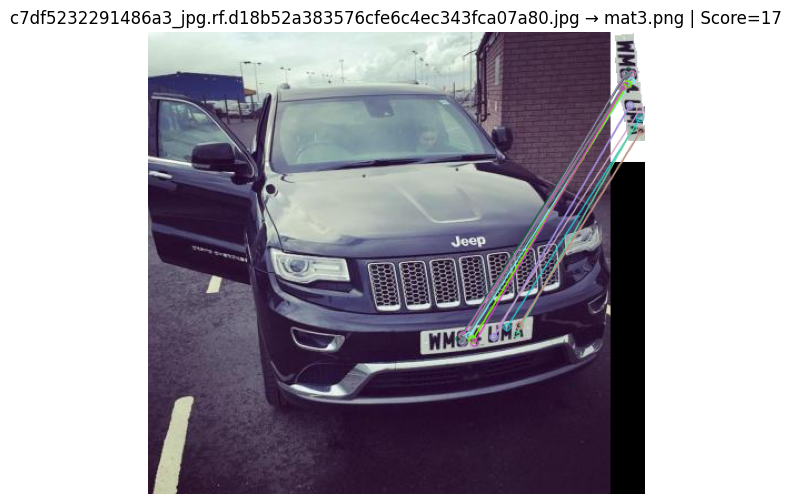


Vérification : b6ecda23586a6ba5_jpg.rf.d737139968dd3f08447305aa7b7f6002.jpg
Descripteurs extraits: (11, 128)
Score obtenu: 1 / 6
Max score from first match: 1
X REFUSÉ  : ( 
Score max trouvé : 1


In [8]:
import cv2 as cv
import pandas as pd
import os
import matplotlib.pyplot as plt

# 1️ Chemins
base_dir = os.getcwd()

matricule_folder = os.path.join(base_dir,  "matricules")
plates_folder = os.path.join(base_dir, "License Plates")
csv_path = os.path.join(plates_folder, "_annotations.csv")

# 2️ Charger CSV
df = pd.read_csv(csv_path)
plates_df = df[df["class"] == "license-plate"].copy()

print("Nombre total d'annotations :", len(df))
print("Nombre de plaques trouvées :", len(plates_df))

# 3️ Initialiser SIFT + Matcher
sift = cv.SIFT_create()
bf = cv.BFMatcher()

def extract_sift_from_image(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray, None)
    return kp, des

# 4️ Construire base autorisée (matricules)
authorized_db = []

for file in os.listdir(matricule_folder):
    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
        path = os.path.join(matricule_folder, file)
        img = cv.imread(path)
        if img is None:
            continue

        kp, des = extract_sift_from_image(img)

        if des is not None:
            authorized_db.append({
                "filename": file,
                "image": img,
                "keypoints": kp,
                "descriptors": des
            })

print("Base autorisée construite :", len(authorized_db))

# 5️ Vérification des voitures test
MATCH_THRESHOLD = 6  # Réduit pour déboguer

def offset_keypoints(keypoints, offset_x, offset_y):
    """Offset keypoints by a given amount"""
    offset_kp = []
    for kp in keypoints:
        new_pt = (kp.pt[0] + offset_x, kp.pt[1] + offset_y)
        new_kp = cv.KeyPoint(new_pt[0], new_pt[1], kp.size, kp.angle, kp.response, kp.octave, kp.class_id)
        offset_kp.append(new_kp)
    return offset_kp

for _, row in plates_df.iterrows():

    filename = row["filename"]
    path = os.path.join(plates_folder, filename)

    img = cv.imread(path)
    if img is None:
        continue

    #  Découper la plaque depuis le CSV
    xmin, ymin, xmax, ymax = map(int, [row["xmin"], row["ymin"], row["xmax"], row["ymax"]])
    
    #  OPTIMIZATION CONDITION
    if xmin == 0 or ymin == 0:
        print(f"!!!!!  Skipped {filename} (invalid bounding box)")
        continue

    plate = img[ymin:ymax, xmin:xmax]

    # Extraire SIFT sur la plaque seulement
    kp_query, des_query = extract_sift_from_image(plate)

    if des_query is None:
        print(f"!!!!! Skipped {filename} (no SIFT descriptors)")
        continue

    best_score = 0
    best_match = None
    best_good = None
    max_score_from_first_match = None  # 🆕 Store max score from first match
    matches_for_same_matricule = []    # 🆕 Track multiple matches for same matricule

    # Comparaison plaque ↔ plaques autorisées
    for item in authorized_db:

        matches = bf.knnMatch(des_query, item["descriptors"], k=2)

        good = []
        for pair in matches:
            if len(pair) == 2:
                m, n = pair
                if m.distance < 0.75 * n.distance:
                    good.append(m)

        score = len(good)

        # 🆕 Store match info for comparison
        if score > 0:
            matches_for_same_matricule.append({
                "filename": item["filename"],
                "score": score,
                "keypoints_count": len(item["keypoints"]),
                "match": item,
                "good_matches": good
            })

        if score > best_score:
            best_score = score
            best_match = item
            best_good = good

    # 🆕 If we found good matches, save the max score from first match
    if matches_for_same_matricule:
        max_score_from_first_match = matches_for_same_matricule[0]["score"]

    # 🆕 If the same matricule has multiple matches, select the one with more keypoints
    if len(matches_for_same_matricule) > 1:
        print(f"⚠️ Multiple matches found ({len(matches_for_same_matricule)} matches):")
        for match_info in matches_for_same_matricule:
            print(f"   - {match_info['filename']}: score={match_info['score']}, keypoints={match_info['keypoints_count']}")
        
        # Select best match with more keypoints
        best_match_info = max(matches_for_same_matricule, key=lambda x: (x['score'], x['keypoints_count']))
        best_match = best_match_info['match']
        best_score = best_match_info['score']
        best_good = best_match_info['good_matches']

    # Décision + Affichage

    print("\n=============================================================================================")
    print("Vérification :", filename)
    print(f"Descripteurs extraits: {des_query.shape if des_query is not None else 'None'}")
    print(f"Score obtenu: {best_score} / {MATCH_THRESHOLD}")
    if max_score_from_first_match is not None:
        print(f"Max score from first match: {max_score_from_first_match}")

    if best_score >= MATCH_THRESHOLD:

        print(" AUTORISÉ : ) ")
        print("Correspond à :", best_match["filename"])
        print("Score :", best_score)

        # 🔹 Offset keypoints from crop to full image coordinates
        kp_query_offsetted = offset_keypoints(kp_query, xmin, ymin)

        result = cv.drawMatches(
            img, kp_query_offsetted,               # voiture complète avec keypoints offsettés
            best_match["image"], best_match["keypoints"],  # matricule base
            best_good, None,
            flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )

        plt.figure(figsize=(12,6))
        plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
        plt.title(f"{filename} → {best_match['filename']} | Score={best_score}")
        plt.axis("off")
        plt.show()

    else:
        print("X REFUSÉ  : ( ")
        print("Score max trouvé :", best_score)
